# Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.switch_backend('Agg')
%matplotlib inline
import seaborn as sns
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats

# Overview

In [2]:
# Load dataset
path = r'..\Datasets\steamcharts.csv'
df = pd.read_csv(path)
df

,month,avg_players,gain,gain_percent,peak_players,name,steam_appid
0,Sep-25,7805.25,883.12,0.1276,13254,Counter-Strike,10
1,Aug-25,6922.13,-449.35,-0.0610,12168,Counter-Strike,10
2,Jul-25,7371.48,-833.5,-0.1016,13951,Counter-Strike,10
3,Jun-25,8204.98,-847.53,-0.0936,15798,Counter-Strike,10
4,May-25,9052.51,-471.31,-0.0495,15333,Counter-Strike,10
...,...,...,...,...,...,...,...
612260,Apr-25,2.48,-0.92,-0.2709,8,The Ditzy Demons Are in Love With Me,802870
612261,Mar-25,3.40,-0.19,-0.0532,11,The Ditzy Demons Are in Love With Me,802870
612262,Feb-25,3.59,-0.65,-0.1527,12,The Ditzy Demons Are in Love With Me,802870
612263,Jan-25,4.23,-0.53,-0.1119,11,The Ditzy Demons Are in Love With Me,802870


In [3]:
# Data with few rows
df.head()

,month,avg_players,gain,gain_percent,peak_players,name,steam_appid
0,Sep-25,7805.25,883.12,0.1276,13254,Counter-Strike,10
1,Aug-25,6922.13,-449.35,-0.0610,12168,Counter-Strike,10
2,Jul-25,7371.48,-833.5,-0.1016,13951,Counter-Strike,10
3,Jun-25,8204.98,-847.53,-0.0936,15798,Counter-Strike,10
4,May-25,9052.51,-471.31,-0.0495,15333,Counter-Strike,10


In [4]:
# Data info to check type data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612265 entries, 0 to 612264
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   month         612265 non-null  object 
 1   avg_players   612265 non-null  float64
 2   gain          612265 non-null  object 
 3   gain_percent  612265 non-null  float64
 4   peak_players  612265 non-null  int64  
 5   name          612265 non-null  object 
 6   steam_appid   612265 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 32.7+ MB


In [5]:
# Statistic Data
df.describe(include='all')

,month,avg_players,gain,gain_percent,peak_players,name,steam_appid
count,612265,6.122650e+05,612265,6.122650e+05,6.122650e+05,612265,612265.000000
unique,159,NaN,54046,NaN,NaN,6725,NaN
top,Apr-19,NaN,-,NaN,NaN,Fallout: New Vegas,NaN
freq,6029,NaN,6728,NaN,NaN,318,NaN
mean,NaN,5.932944e+02,NaN,1.471370e+01,1.192778e+03,NaN,346921.739786
std,NaN,1.122613e+04,NaN,3.085757e+03,2.105437e+04,NaN,214347.204931
min,NaN,0.000000e+00,NaN,-1.000000e+00,0.000000e+00,NaN,10.000000
25%,NaN,2.530000e+00,NaN,-1.744000e-01,1.000000e+01,NaN,221260.000000
50%,NaN,1.061000e+01,NaN,-2.040000e-02,3.200000e+01,NaN,336610.000000
75%,NaN,6.046000e+01,NaN,1.531000e-01,1.620000e+02,NaN,502800.000000


# Data cleaning and preprocessing

In [6]:
# Convert 'month' columns to datetime types
df['date'] = pd.to_datetime(df['month'], format='%b-%y', errors='coerce')
df['year'] = df['date'].dt.year
df['month_num'] = df['date'].dt.month
# Convert numeric columns to numeric type
numeric_col = df.drop(columns=['month','name','date']).columns
for col in numeric_col:
    df[col] = pd.to_numeric(df[col], errors='coerce')
# Check data types after convert
# sort by game and date
df = df.sort_values(['steam_appid', 'date'])
print(f"Loaded {len(df):,} records")

Loaded 612,265 records


In [7]:
df['date'].dt.strftime('%Y-%m-%d')

158       2012-07-01
157       2012-08-01
156       2012-09-01
155       2012-10-01
154       2012-11-01
             ...    
612259    2025-05-01
612258    2025-06-01
612257    2025-07-01
612256    2025-08-01
612255    2025-09-01
Name: date, Length: 612265, dtype: object

# 1. Clustering

## Feature Engineering for Clustering

In [8]:
def calculate_trajectory_features(group):
    if len(group) < 3:
        return None
    features = {
        'mean_players': group['avg_players'].mean(),
        'max_players': group['avg_players'].max(),
        'min_players': group['avg_players'].min(),
        'std_players': group['avg_players'].std(),
        'cv': group['avg_players'].std() / (group['avg_players'].mean() + 1),  # coefficient of variation
        'total_months': len(group),
        'growth_rate': group['gain_percent'].mean(),
        'peak_to_mean_ratio': group['avg_players'].max() / (group['avg_players'].mean() + 1),
        'months_declining': (group['gain'] < 0).sum() / len(group),
        'final_to_peak_ratio': group['avg_players'].iloc[-1] / (group['avg_players'].max() + 1)
    }
    return pd.Series(features)
game_features = df.groupby('name').apply(calculate_trajectory_features).dropna()
print(f"Created features for {len(game_features)} games")
game_features.head()

Created features for 6660 games


,mean_players,max_players,min_players,std_players,cv,total_months,growth_rate,peak_to_mean_ratio,months_declining,final_to_peak_ratio
name,,,,,,,,,,
Chinese PaladinSword and Fairy 5 Prequel,59.126082,141.63,5.23,26.405695,0.439172,97.0,0.269796,2.355550,0.536082,0.344808
Fieldrunners 2,13.705948,253.91,5.17,23.188083,1.576783,153.0,-0.006853,17.265803,0.496732,0.024244
#KILLALLZOMBIES,6.455750,106.23,0.02,15.513927,2.080800,80.0,1.920467,14.248064,0.475000,0.014268
#monstercakes,38.441961,134.36,0.18,24.868169,0.630500,102.0,0.858149,3.406524,0.470588,0.335476
(Chinese PaladinSword and Fairy 4),95.056633,301.85,0.34,57.258486,0.596091,98.0,3.449732,3.142417,0.510204,0.259733


In [9]:
# filter out games with very low player counts to focus on meaningful patterns
game_features_filtered = game_features[game_features['mean_players'] >= 5].copy()
print(f"Filtered to {len(game_features_filtered)} games with mean >= 5 players")

Filtered to 3804 games with mean >= 5 players


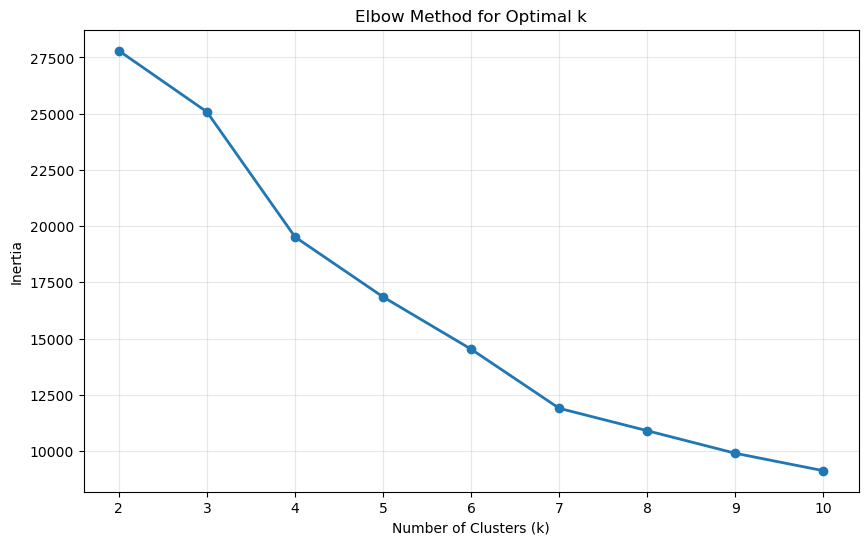

In [10]:
# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(game_features_filtered)

# elbow method to find optimal K
wcss = []
k_range = range(2,11)
for i in k_range:
    kmeans = KMeans(i)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# use k=5 or k=6 clusters based on elbow
n_clusters = 6
kmeans = KMeans(n_clusters= n_clusters, init='k-means++', random_state=42)
game_features_filtered['cluster'] = kmeans.fit_predict(features_scaled)

print(f"Cluster distribution:")
print(game_features_filtered['cluster'].value_counts())

Cluster distribution:
cluster
0    1419
5    1249
2     703
4     420
3      11
1       2
Name: count, dtype: int64


In [12]:
cluster_summary = game_features_filtered.groupby('cluster').agg({
    'mean_players': 'mean',
    'max_players': 'mean',
    'cv': 'mean',
    'growth_rate': 'mean',
    'months_declining': 'mean',
    'final_to_peak_ratio': 'mean',
    'total_months': 'mean'
}).round(2)

print("Cluster Characteristics:")
print(cluster_summary)

Cluster Characteristics:
         mean_players  max_players    cv  growth_rate  months_declining  \
cluster                                                                   
0              406.10      1804.41  0.78         4.33              0.55   
1           410055.05   1351202.08  0.74         0.09              0.47   
2              972.63      2578.35  0.51        10.35              0.49   
3            42386.56    136390.88  0.56         0.01              0.53   
4              161.90      3141.44  2.51       170.94              0.56   
5              269.75      1682.42  1.07        31.89              0.56   

         final_to_peak_ratio  total_months  
cluster                                     
0                       0.12        138.11  
1                       0.50        131.00  
2                       0.54        119.36  
3                       0.34        109.91  
4                       0.02        107.35  
5                       0.09         85.91  


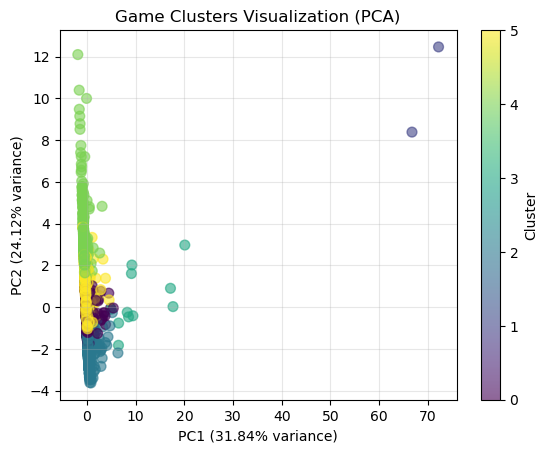

In [13]:
# visualize clusters in 2D (using PCA-like approach)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_scaled)
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                     c=game_features_filtered['cluster'], cmap='viridis', 
                     alpha=0.6, s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Game Clusters Visualization (PCA)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# show example games from each cluster
for cluster_id in range(n_clusters):
    print(f"\nCluster {cluster_id} - Top 5 games by avg players:")
    cluster_games = game_features_filtered[game_features_filtered['cluster'] == cluster_id]
    top_games = cluster_games.nlargest(5, 'mean_players')
    for idx, row in top_games.iterrows():
        print(f"{idx}: {row['mean_players']:.0f} avg players")


Cluster 0 - Top 5 games by avg players:
ARK: Survival Evolved: 40965 avg players
Rocket League®: 29932 avg players
Unturned: 24082 avg players
Terraria: 23155 avg players
Path of Exile: 21192 avg players

Cluster 1 - Top 5 games by avg players:
Counter-Strike 2: 471709 avg players
PUBG: BATTLEGROUNDS: 348401 avg players

Cluster 2 - Top 5 games by avg players:
Wallpaper Engine: 40566 avg players
Warframe: 37252 avg players
Stardew Valley: 27869 avg players
War Thunder: 25249 avg players
Garry's Mod: 24833 avg players

Cluster 3 - Top 5 games by avg players:
Grand Theft Auto V Legacy: 77629 avg players
HELLDIVERS™ 2: 67954 avg players
Team Fortress 2: 61088 avg players
Rust: 53738 avg players
Tom Clancy's Rainbow Six® Siege X: 52298 avg players

Cluster 4 - Top 5 games by avg players:
Total War: THREE KINGDOMS: 7763 avg players
Z1 Battle Royale: 7481 avg players
Tom Clancy’s The Division™: 3014 avg players
Total War: WARHAMMER: 2973 avg players
METAL GEAR SOLID V: THE PHANTOM PAIN: 254

# 2. Regression

## Feature Engineering

In [15]:
# create lag features and rolling stats for each game
def create_prediction_features(group):
    group = group.sort_values('date').copy()
    
    # lag features
    for i in [1, 2, 3, 6]:
        group[f'avg_players_lag_{i}'] = group['avg_players'].shift(i)
        group[f'gain_lag_{i}'] = group['gain'].shift(i)
    
    # rolling statistics
    group['avg_players_roll_3'] = group['avg_players'].rolling(3, min_periods=1).mean()
    group['avg_players_roll_6'] = group['avg_players'].rolling(6, min_periods=1).mean()
    group['gain_roll_3'] = group['gain'].rolling(3, min_periods=1).mean()
    
    # trend features
    group['trend'] = group['avg_players'].pct_change()
    group['momentum'] = group['gain'].rolling(3, min_periods=1).mean()
    
    return group

df_features = df.groupby('steam_appid').apply(create_prediction_features).reset_index(drop=True)
print(f"Created features: {len(df_features)} records")

Created features: 612265 records


In [16]:
# add time-based features
df_features['month_sin'] = np.sin(2 * np.pi * df_features['month_num'] / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['month_num'] / 12)

# target: next month's player count
df_features['target'] = df_features.groupby('steam_appid')['avg_players'].shift(-1)

# drop rows with missing values
df_ml = df_features.dropna(subset=['target']).copy()
print(f'Final dataset: {len(df_ml)} records')

Final dataset: 605536 records


In [17]:
df_features['target']

0         33095.80
1         29432.56
2         28836.29
3         29669.97
4         31996.07
            ...   
612260        3.68
612261        3.54
612262        2.53
612263        2.44
612264         NaN
Name: target, Length: 612265, dtype: float64

In [18]:
df_ml['avg_players_lag_3']

0              NaN
1              NaN
2              NaN
3         34139.20
4         33095.80
            ...   
612259        4.23
612260        3.59
612261        3.40
612262        2.48
612263        4.48
Name: avg_players_lag_3, Length: 605536, dtype: float64

In [19]:
# select features
feature_cols = ['avg_players','avg_players_lag_1','avg_players_lag_2','avg_players_lag_3', 'avg_players_roll_3','avg_players_roll_6',
                'gain_lag_1','gain_lag_2','gain_roll_3','momentum','month_sin','month_cos']

# drop rows with NaN in ANY of our feature columns or target
df_ml_clean = df_ml[feature_cols + ['target','date']].dropna().copy()

# select feature and target
X = df_ml_clean[feature_cols]
y = df_ml_clean['target']

print(f"After removing NaNs: {len(X)} records")

# temporal split - train on older data, test on recent
split_date = df_ml_clean['date'].quantile(0.8)
train_mask = df_ml_clean['date'] <= split_date
test_mask = df_ml_clean['date'] > split_date

# splittinf data into train and test set
X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Train set: {len(X_train)} records")
print(f"Test set: {len(X_test)} records")
print(f"Split date: {split_date}")

After removing NaNs: 585546 records
Train set: 472489 records
Test set: 113057 records
Split date: 2023-04-01 00:00:00


In [ ]:
# try multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

result = {}
for name, model in models.items():
    print(f'Training {name}...')
    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    mae = mean_absolute_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)

    result[name] = {'RMSE':rmse, 'MAE':mae, 'r2':r2,'model':model}
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²: {r2:.4f}")

Training Linear Regression...
  RMSE: 1597.20
  MAE: 121.82
  R²: 0.9895
Training Random Forest...


In [ ]:
# visualize predictions vs actual
best_model_name = min(result.keys(), key=lambda k: result[k]['RMSE'])
best_model = result[best_model_name]['model']
y_pred = best_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# scatter plot
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Players')
axes[0].set_ylabel('Predicted Players')
axes[0].set_title(f'{best_model_name} - Predictions vs Actual')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# residuals
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Players')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()

In [ ]:
# feature importance (for Random Forest)
if 'Random Forest' in result:
    rf_model = result['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature' : feature_cols,
        'importance': rf_model.feature_importances_         
    }).sort_values(by='importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance - Random Forest')
    plt.tight_layout()
    plt.show()

In [ ]:
# remove current month from features - only use historical lags
forecast_feature_cols = ['avg_players_lag_1', 'avg_players_lag_2', 'avg_players_lag_3',
                         'gain_lag_1', 'gain_lag_2', 'avg_players_roll_3', 'avg_players_roll_6',
                         'gain_roll_3', 'momentum', 'month_sin', 'month_cos']

# use name cleaned dataset
X_forecast = df_ml_clean[forecast_feature_cols]
y_forecast = df_ml_clean['target']
dates = df_ml_clean['date']

# recreate temporal split with aligned indices
train_mask_f = dates <= split_date
test_mask_f = dates > split_date

X_train_f = X_forecast[train_mask_f]
X_test_f = X_forecast[test_mask_f]
y_train_f = y_forecast[train_mask_f]
y_test_f = y_forecast[test_mask_f]

print(f"True Forecasting - Train: {len(X_train_f)}, Test: {len(X_test_f)}")

In [ ]:
# train models for true forecasting
forecast_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

forecast_result = {}
for name, model in forecast_models.items():
    print(f"\nTraining {name} (No current Month)...")
    model.fit(X_train_f, y_train_f)

    y_pred_f = model.predict(X_test_f)

    rmse = np.sqrt(mean_squared_error(y_test_f, y_pred_f))
    mae = mean_absolute_error(y_test_f, y_pred_f)
    r2 = r2_score(y_test_f, y_pred_f)

    forecast_result[name] = {'RMSE': rmse, 'MAE': mae, 'r2': r2, 'model': model}
    
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²: {r2:.4f}")

In [ ]:
# Compare baseline vs true forecasting
comparison_data = []
for name in ['Linear Regression', 'Random Forest']:
    comparison_data.append({
        'Model': f"{name}\n(with current month)",
        'R2': result[name]['r2'],
        'MAE': result[name]['MAE']
    })
    comparison_data.append({
        'Model': f"{name}\n(historical only)",
        'R2': forecast_result[name]['r2'],
        'MAE': forecast_result[name]['MAE']
    })
comparison_df = pd.DataFrame(comparison_data)

fig, axes = plt.subplots(1, 2, figsize=(20,8))

# R2 comparison
x_pos = np.arange(len(comparison_df))
colors = ['#1f77b4', '#ff7f0e', '#1f77b4', '#ff7f0e']
axes[0].bar(x_pos, comparison_df['R2'], color=colors, alpha=0.7, edgecolor='black')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], fontsize=9)
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Comparison - R² Score')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# MAE Comparison
axes[1].bar(x_pos, comparison_df['MAE'], color=colors, alpha=0.7, edgecolor='black')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_df['Model'], fontsize=9)
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_title('Model Comparison - MAE (Lower is Better)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# feature importance for true forecasting
rf_forecast = forecast_result['Random Forest']['model']
feature_importance_forecast = pd.DataFrame({
    'feature': forecast_feature_cols,
    'importance': rf_forecast.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_importance_forecast['feature'], feature_importance_forecast['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - True Forecasting (Historical Data Only)')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance_forecast.head())

In [ ]:
# Generate predictions from best model
best_forecast_model = forecast_result['Random Forest']['model']
y_pred_forecast = best_forecast_model.predict(X_test_f)

print(f"Generated {len(y_pred_forecast)} predictions")

In [ ]:
# better approach - keep game identifiers throughout
# recreate test set with all needed columns from df_ml
test_cols = ['date','steam_appid'] + forecast_feature_cols + ['target']
test_full_data = df_ml[test_cols].dropna()

# recreate the clean dataset with steam appid
test_full_data_clean = test_full_data[test_full_data['date'] > split_date].copy()

# get predictions for this test set
X_test_viz = test_full_data_clean[forecast_feature_cols]
y_test_viz = test_full_data_clean['target']
y_pred_viz = best_forecast_model.predict(X_test_viz)

# create results dataframe
test_results = test_full_data_clean[['date', 'steam_appid']].copy()
test_results['actual'] = y_test_viz.values
test_results['predicted'] = y_pred_viz

# merge with game names
test_results = test_results.merge(df[['steam_appid','name']].drop_duplicates(),on='steam_appid', how='left')

print(f"Test results: {len(test_results)} predictions")
print(f"Unique games: {test_results['name'].nunique()}")
print(f"Sample games: {test_results['name'].value_counts().head()}")

# visualize
games_to_visualize = ['PUBG: BATTLEGROUNDS', 'Counter-Strike 2', 'Dota 2', 'Rust']

fig, axes = plt.subplots(len(games_to_visualize), 1, figsize=(14, 8))

for idx, game in enumerate(games_to_visualize):
    game_full = df[df['name'] == game].sort_values('date')
    game_test = test_results[test_results['name'] == game].sort_values('date')
    
    if len(game_full) > 0:
        axes[idx].plot(game_full['date'], game_full['avg_players'], 
                      label='Actual (Full History)', linewidth=2, color='blue', alpha=0.7)
        
        if len(game_test) > 0:
            axes[idx].plot(game_test['date'], game_test['predicted'], 
                          label='Model Prediction', linewidth=2.5, 
                          color='red', linestyle='--', marker='o', markersize=4)
            print(f"{game}: {len(game_test)} test predictions")
        else:
            print(f"{game}: NO test predictions found")
        
        axes[idx].axvline(x=split_date, color='green', linestyle=':', linewidth=2, label='Train/Test Split')
        axes[idx].set_ylabel('Average Players')
        axes[idx].set_title(f'{game} - Time Series: Actual vs Predicted')
        axes[idx].legend(loc='best')
        axes[idx].grid(True, alpha=0.3)
    else:
        axes[idx].text(0.5, 0.5, f'{game} - No data available', 
                      ha='center', va='center', transform=axes[idx].transAxes)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [ ]:
# TOP 5 GAMES VISUALIZATION
print("="*60)
print("TOP 5 GAMES - ACTUAL VS PREDICTED")
print("="*60)

# get top 5 games by average player count
top_5_games = df.groupby('name')['avg_players'].mean().nlargest(5).index.tolist()
print(f"\nTop 5 games by average player count:")
for i, game in enumerate(top_5_games, 1):
    avg = df[df['name'] == game]['avg_players'].mean()
    print(f"  {i}. {game}: {avg:,.0f} avg players")

# visualize top 5
fig, axes = plt.subplots(len(top_5_games), 1, figsize=(14, 14))

for idx, game in enumerate(top_5_games):
    game_full = df[df['name'] == game].sort_values('date')
    game_test = test_results[test_results['name'] == game].sort_values('date')
    
    if len(game_full) > 0:
        axes[idx].plot(game_full['date'], game_full['avg_players'], 
                      label='Actual (Full History)', linewidth=2, color='blue', alpha=0.7)
        
        if len(game_test) > 0:
            axes[idx].plot(game_test['date'], game_test['predicted'], 
                          label='Model Prediction', linewidth=2.5, 
                          color='red', linestyle='--', marker='o', markersize=4)
            
            # calculate accuracy for this game
            game_mae = np.abs(game_test['actual'] - game_test['predicted']).mean()
            game_mape = (np.abs((game_test['actual'] - game_test['predicted']) / (game_test['actual'] + 1)).mean() * 100)
            print(f"\n{game}:")
            print(f"  Test predictions: {len(game_test)}")
            print(f"  MAE: {game_mae:.2f} players")
            print(f"  MAPE: {game_mape:.2f}%")
        
        axes[idx].axvline(x=split_date, color='green', linestyle=':', linewidth=2, 
                         label='Train/Test Split', alpha=0.6)
        axes[idx].set_ylabel('Average Players')
        axes[idx].set_title(f'#{idx+1}: {game} - Actual vs Predicted Player Counts')
        axes[idx].legend(loc='best')
        axes[idx].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [ ]:
# analyze what's ACTUALLY driving the predictions
print("="*60)
print("WHAT'S REALLY PREDICTING THE FUTURE?")
print("="*60)

# look at correlation between features and target in test set
test_correlations = pd.DataFrame({
    'feature': forecast_feature_cols,
    'correlation_with_target': [test_full_data_clean[col].corr(test_full_data_clean['target']) 
                                for col in forecast_feature_cols]
}).sort_values('correlation_with_target', ascending=False)

print("\nCorrelation with Next Month's Player Count:")
print(test_correlations)

# check autocorrelation
print("\n" + "="*60)
print("AUTOCORRELATION TEST")
print("="*60)
sample_game = 'Counter-Strike 2'
game_data = df[df['name'] == sample_game].sort_values('date')[['date', 'avg_players']].tail(50)
game_data['next_month'] = game_data['avg_players'].shift(-1)
correlation = game_data['avg_players'].corr(game_data['next_month'])
print(f"\n{sample_game}:")
print(f"Correlation between this month and next month: {correlation:.4f}")
print(f"This means: {correlation**2:.2%} of next month's value is explained by this month!")

# show the "naive" baseline
print("\n" + "="*60)
print("NAIVE BASELINE COMPARISON")
print("="*60)
print("What if we just predicted: next_month = last_month?")
naive_predictions = test_full_data_clean['avg_players_lag_1']
naive_mae = mean_absolute_error(y_test_viz, naive_predictions)
naive_rmse = np.sqrt(mean_squared_error(y_test_viz, naive_predictions))
naive_r2 = r2_score(y_test_viz, naive_predictions)

print(f"\nNaive Model (just use lag_1 as prediction):")
print(f"  MAE: {naive_mae:.2f}")
print(f"  RMSE: {naive_rmse:.2f}")
print(f"  R²: {naive_r2:.4f}")

print(f"\nOur Random Forest Model:")
print(f"  MAE: {forecast_result['Random Forest']['MAE']:.2f}")
print(f"  RMSE: {forecast_result['Random Forest']['RMSE']:.2f}")
print(f"  R²: {forecast_result['Random Forest']['r2']:.4f}")

print(f"\nImprovement over naive baseline:")
print(f"  MAE improvement: {((naive_mae - forecast_result['Random Forest']['MAE']) / naive_mae * 100):.2f}%")